In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys 
sys.path.append("diachronic-p2v") 
%aimport p2v

# Drafts

In [6]:
model = p2v.P2V()
d, w = 100, 10

2024-11-13 10:33:20 -- start loading Mag_venue_info_df
2024-11-13 10:33:20 -- finish.
2024-11-13 10:33:20 -- start loading labeled_journal_info_df
2024-11-13 10:33:20 -- finish.


In [ ]:
abbr_dict = {'Trends in Ecology and Evolution': 'Trends Ecol. Evol.', 
             'Philosophical Transactions of the Royal Society B': 'PTSB',	
             'Ecology Letters': 'Ecol. Lett.',	
             'International Journal of Computer Vision': 'Int. J. Comput. Vis.',
             'Botanical Journal of Scotland': 'Bot. J. Scotl.',
             'Proceedings of The Royal Society B: Biological Sciences': 'PRSB',
             'Journal of Machine Vision and Applications': 'J. Mach. Vis. Appl.',
             'The Journal of Experimental Biology': 'J. Exp. Biol.',
             'Current Topics in Developmental Biology': 'Curr. Top. Dev. Biol.'}

In [80]:
import pandas as pd
import matplotlib.patheffects as path_effects
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text 
from utils import prinT
from sklearn.manifold import TSNE
from scipy.linalg import orthogonal_procrustes
import numpy as np

def plot_knn_map(start_year: int, end_year: int, ref_start_year: int, ref_end_year: int, d: int, w: int, model: p2v.P2V,
                 auto_zoom=False, crop=False, up_lim=None, low_lim=None, left_lim=None, right_lim=None,
                 annotate=False, center_VID=None, neighbor_VID_list=None, abbr_dict=None,
                 title=True, axis_off=True):
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(ref_start_year, ref_end_year, start_year, end_year))

    wv = model.load_wv(start_year, end_year, 100, 10)
    ref_wv = model.load_wv(ref_start_year, ref_end_year, 100, 10)

    VIDs = wv.index_to_key
    ref_VIDs = ref_wv.index_to_key
    shared_VIDs = list(set(VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))

    idx = [wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]

    vectors = wv.get_normed_vectors()[idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]

    prinT("start aligning...")
    R, sca = orthogonal_procrustes(vectors, ref_vectors)
    aligned_vectors = np.dot(wv.get_normed_vectors(), R)

    prinT("start reducing dimension...")
    num_dimensions = 2

    # extract the words & their vectors, as numpy arrays
    vectors = aligned_vectors

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=2023)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    prinT("finish.")
    
    wv_2d = {'x_val': x_vals,
             'y_val': y_vals,
             'VID': VIDs}
    
    plot_df = pd.DataFrame(wv_2d)

    fig = plt.figure(figsize=(10, 10), dpi=300)
    ax1 = plt.gca()
    if title:
        ax1.set_title("Neighbors of {} ({}s)".format(abbr_dict[center_vname], start_year))
    ax1.set_aspect('equal')
    
    if annotate:
        point_alpha = 0
    else:
        point_alpha = 1.0
    
    sns.scatterplot(data=plot_df, 
                    x='x_val', 
                    y='y_val', 
                    alpha=point_alpha,
                    s=5,
                    ax=ax1)
    if axis_off:  
        ax1.axis('off')
    
    if annotate:
        texts = []
        text = plt.text(plot_df[plot_df.VID==center_VID].x_val.values[0], 
                                plot_df[plot_df.VID==center_VID].y_val.values[0], 
                                abbr_dict[center_vname]+f'({str(start_year)[-2:]}s)',
                                fontsize=20,
                                color='k',
                                fontweight='bold',)
        texts.append(text)
        for VID in neighbor_VID_list:
            text = plt.text(plot_df[plot_df.VID==VID].x_val.values[0], 
                            plot_df[plot_df.VID==VID].y_val.values[0], 
                            abbr_dict[model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==VID]['OriginalVenue'].values[0]]+f'({str(start_year)[-2:]}s)',
                            fontsize=12,
                            color='gray',)
            texts.append(text)
        
        neighbor_VID_list.append(center_VID)
        neighbor_df = plot_df.loc[plot_df.VID.isin(neighbor_VID_list)]

        if auto_zoom:
            x_span = neighbor_df.x_val.max() - neighbor_df.x_val.min()
            y_span = neighbor_df.y_val.max() - neighbor_df.y_val.min()
            
            ax1.set_xlim(neighbor_df.x_val.min() - x_span*0.1, neighbor_df.x_val.max() + x_span*0.1)
            ax1.set_ylim(neighbor_df.y_val.min() - y_span*0.1, neighbor_df.y_val.max() + y_span*0.1)
        if crop:
            ax1.set_xlim(left_lim, right_lim)
            ax1.set_ylim(low_lim, up_lim)
        
        adjust_text(texts)

    return fig

In [36]:
ref_start_year, ref_end_year = 1970, 1979

2024-11-12 00:11:16 -- start loading word vectors...
2024-11-12 00:11:16 -- word vectors loaded, and its shape is: (5686, 100)
number of neighbors:  3
Philosophical Transactions of the Royal Society B
Current Topics in Developmental Biology
The Journal of Experimental Biology
-----------------------
2024-11-12 00:11:16 -- start comparing 1970-1979 with the 1970-1979
2024-11-12 00:11:16 -- start loading word vectors...
2024-11-12 00:11:16 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-12 00:11:16 -- start loading word vectors...
2024-11-12 00:11:16 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-12 00:11:16 -- the number of shared VIDs between this two decades: 5686
2024-11-12 00:11:16 -- start aligning...
2024-11-12 00:11:16 -- start reducing dimension...
2024-11-12 00:11:23 -- finish.


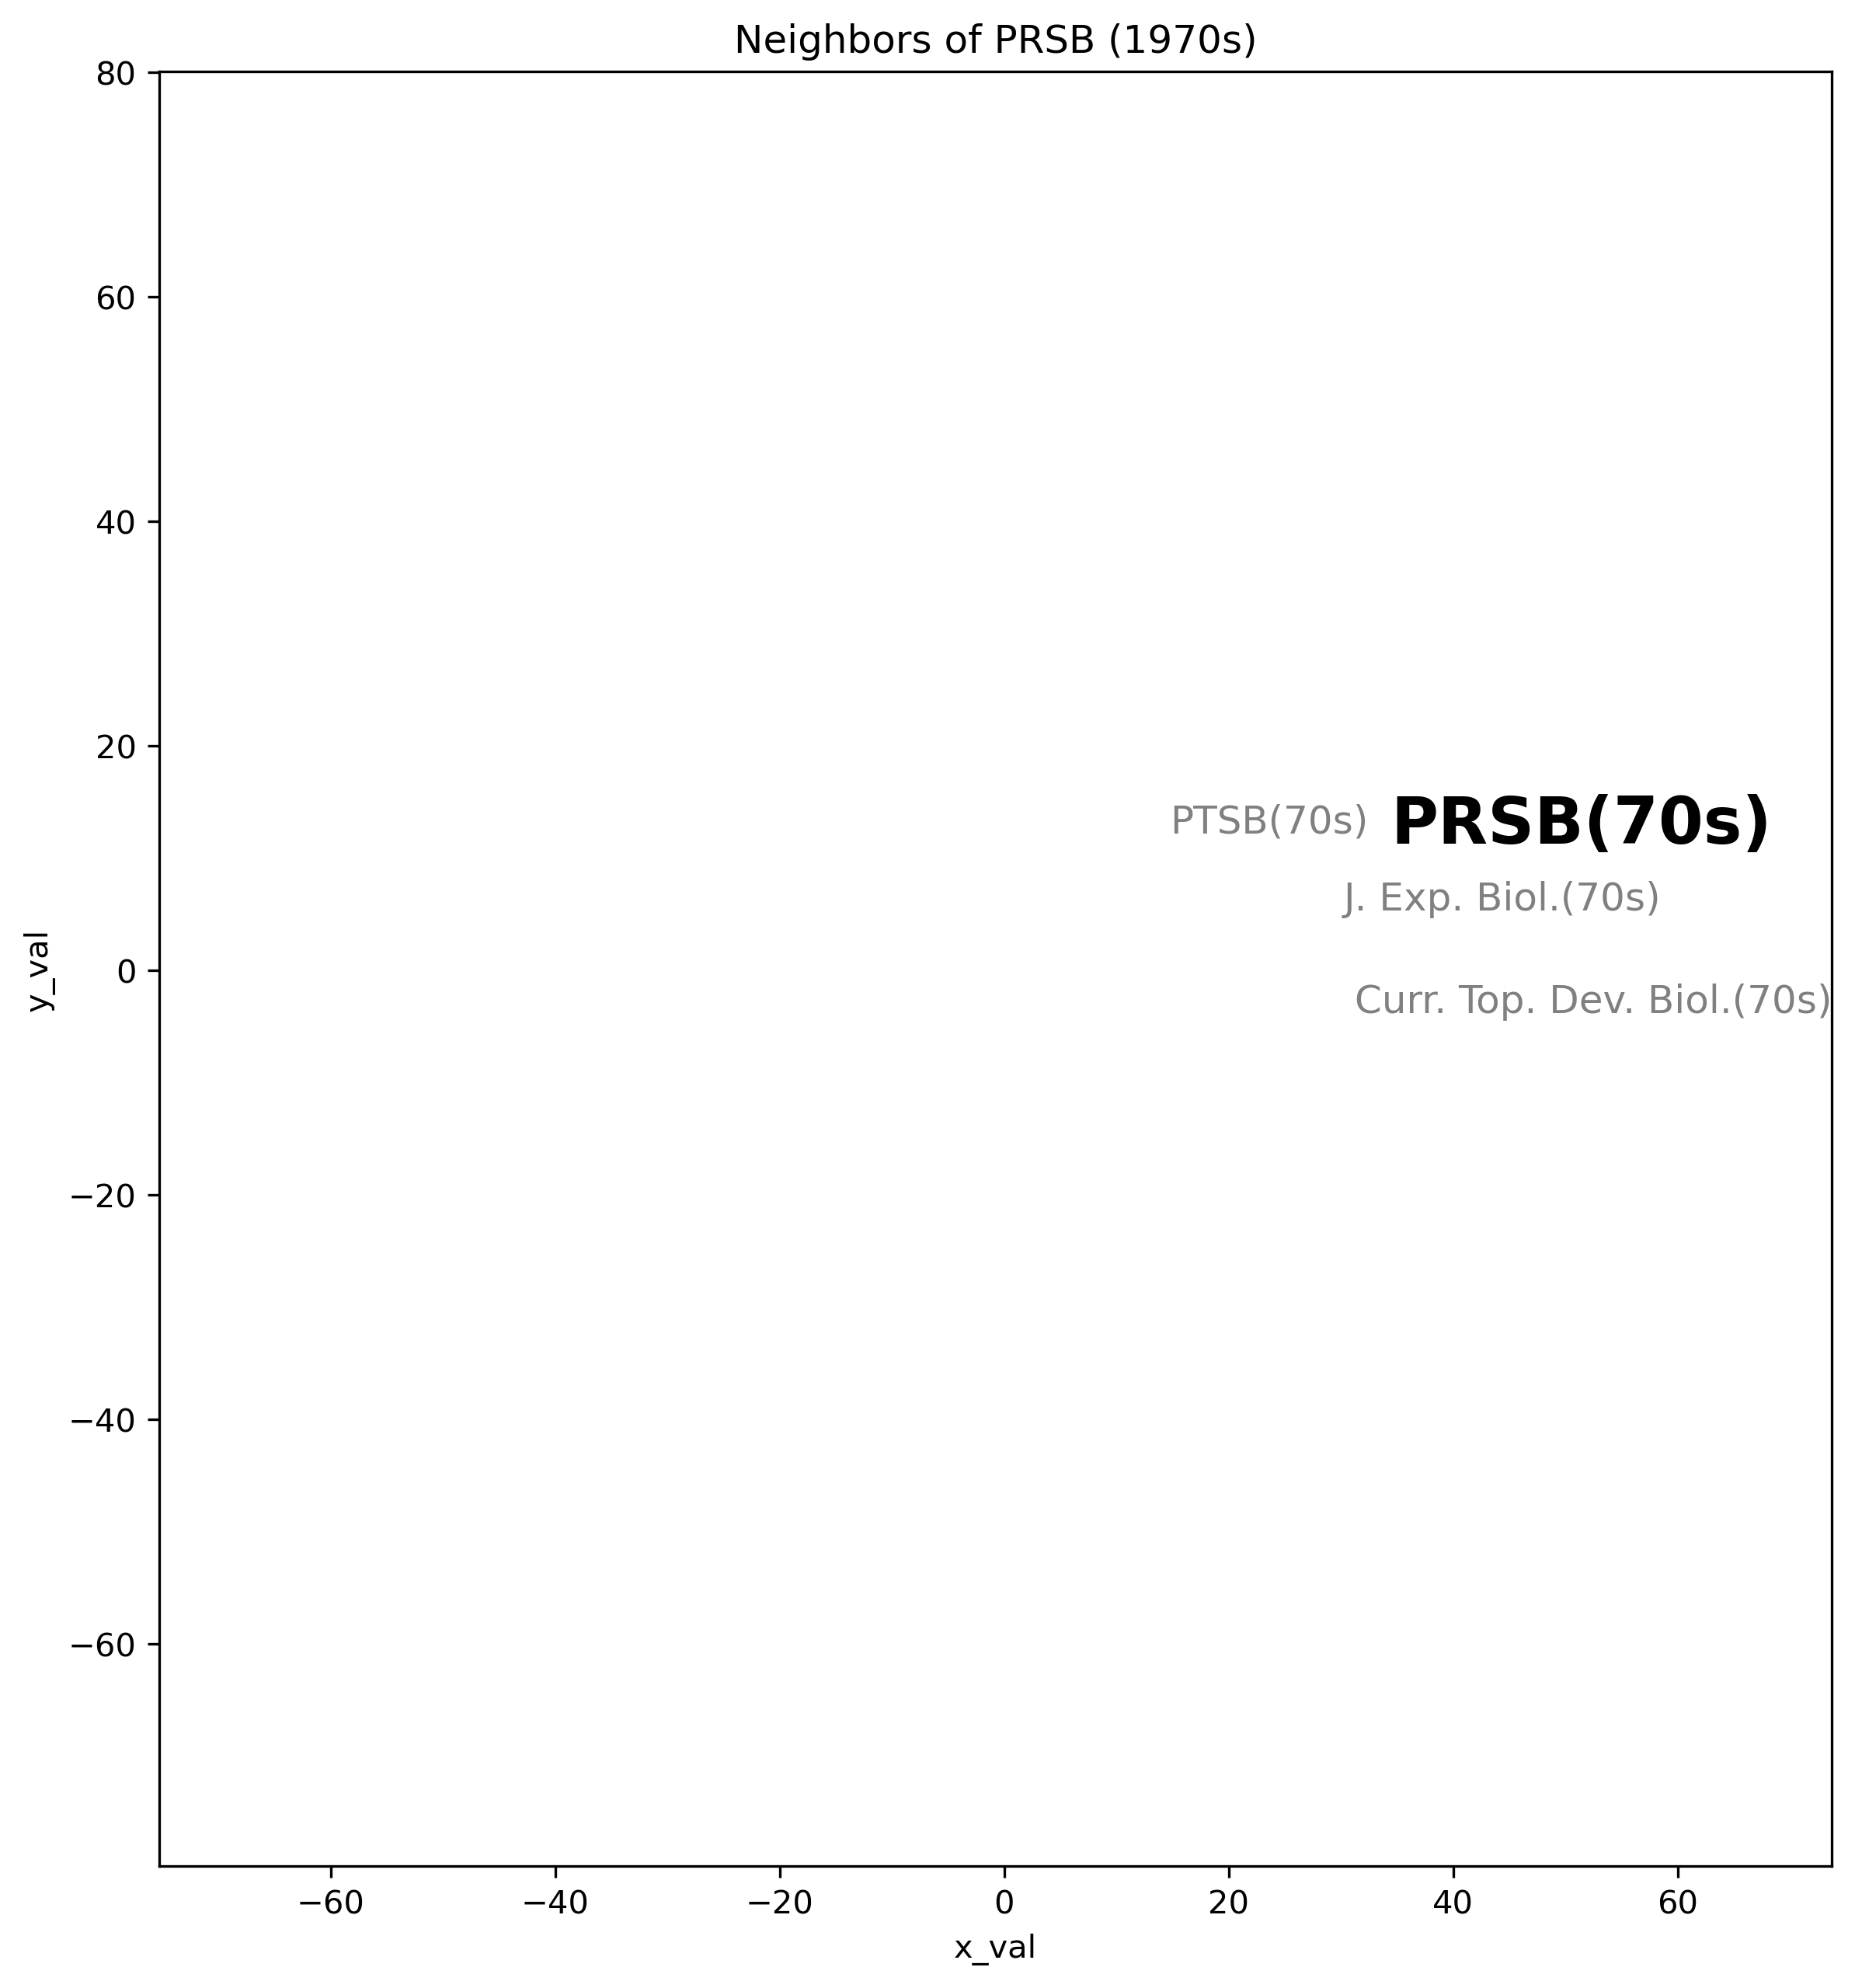

In [81]:
start_year, end_year = 1970, 1979
wv = model.load_wv(start_year, end_year, 100, 10)

tups = wv.most_similar(center_VID, topn=3)
neighbor_VID_list = []
for tup in tups:
    neighbor_VID = tup[0]
    neighbor_VID_list.append(neighbor_VID)

print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==neighbor_VID]['OriginalVenue'].values[0])

fig2 = plot_knn_map(start_year, end_year, ref_start_year, ref_end_year,100, 10, model,
                    axis_off=False, auto_zoom=False, crop=False, left_lim=30, right_lim=33, low_lim=-64, up_lim=-60, 
                    annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

2024-11-12 00:08:53 -- start loading word vectors...
2024-11-12 00:08:53 -- word vectors loaded, and its shape is: (9337, 100)
number of neighbors:  3
International Journal of Computer Vision
Botanical Journal of Scotland
Journal of Machine Vision and Applications
-----------------------
2024-11-12 00:08:53 -- start comparing 1970-1979 with the 1980-1989
2024-11-12 00:08:53 -- start loading word vectors...
2024-11-12 00:08:53 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-12 00:08:53 -- start loading word vectors...
2024-11-12 00:08:53 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-12 00:08:53 -- the number of shared VIDs between this two decades: 5144
2024-11-12 00:08:53 -- start aligning...
2024-11-12 00:08:53 -- start reducing dimension...


2024-11-12 00:09:07 -- finish.


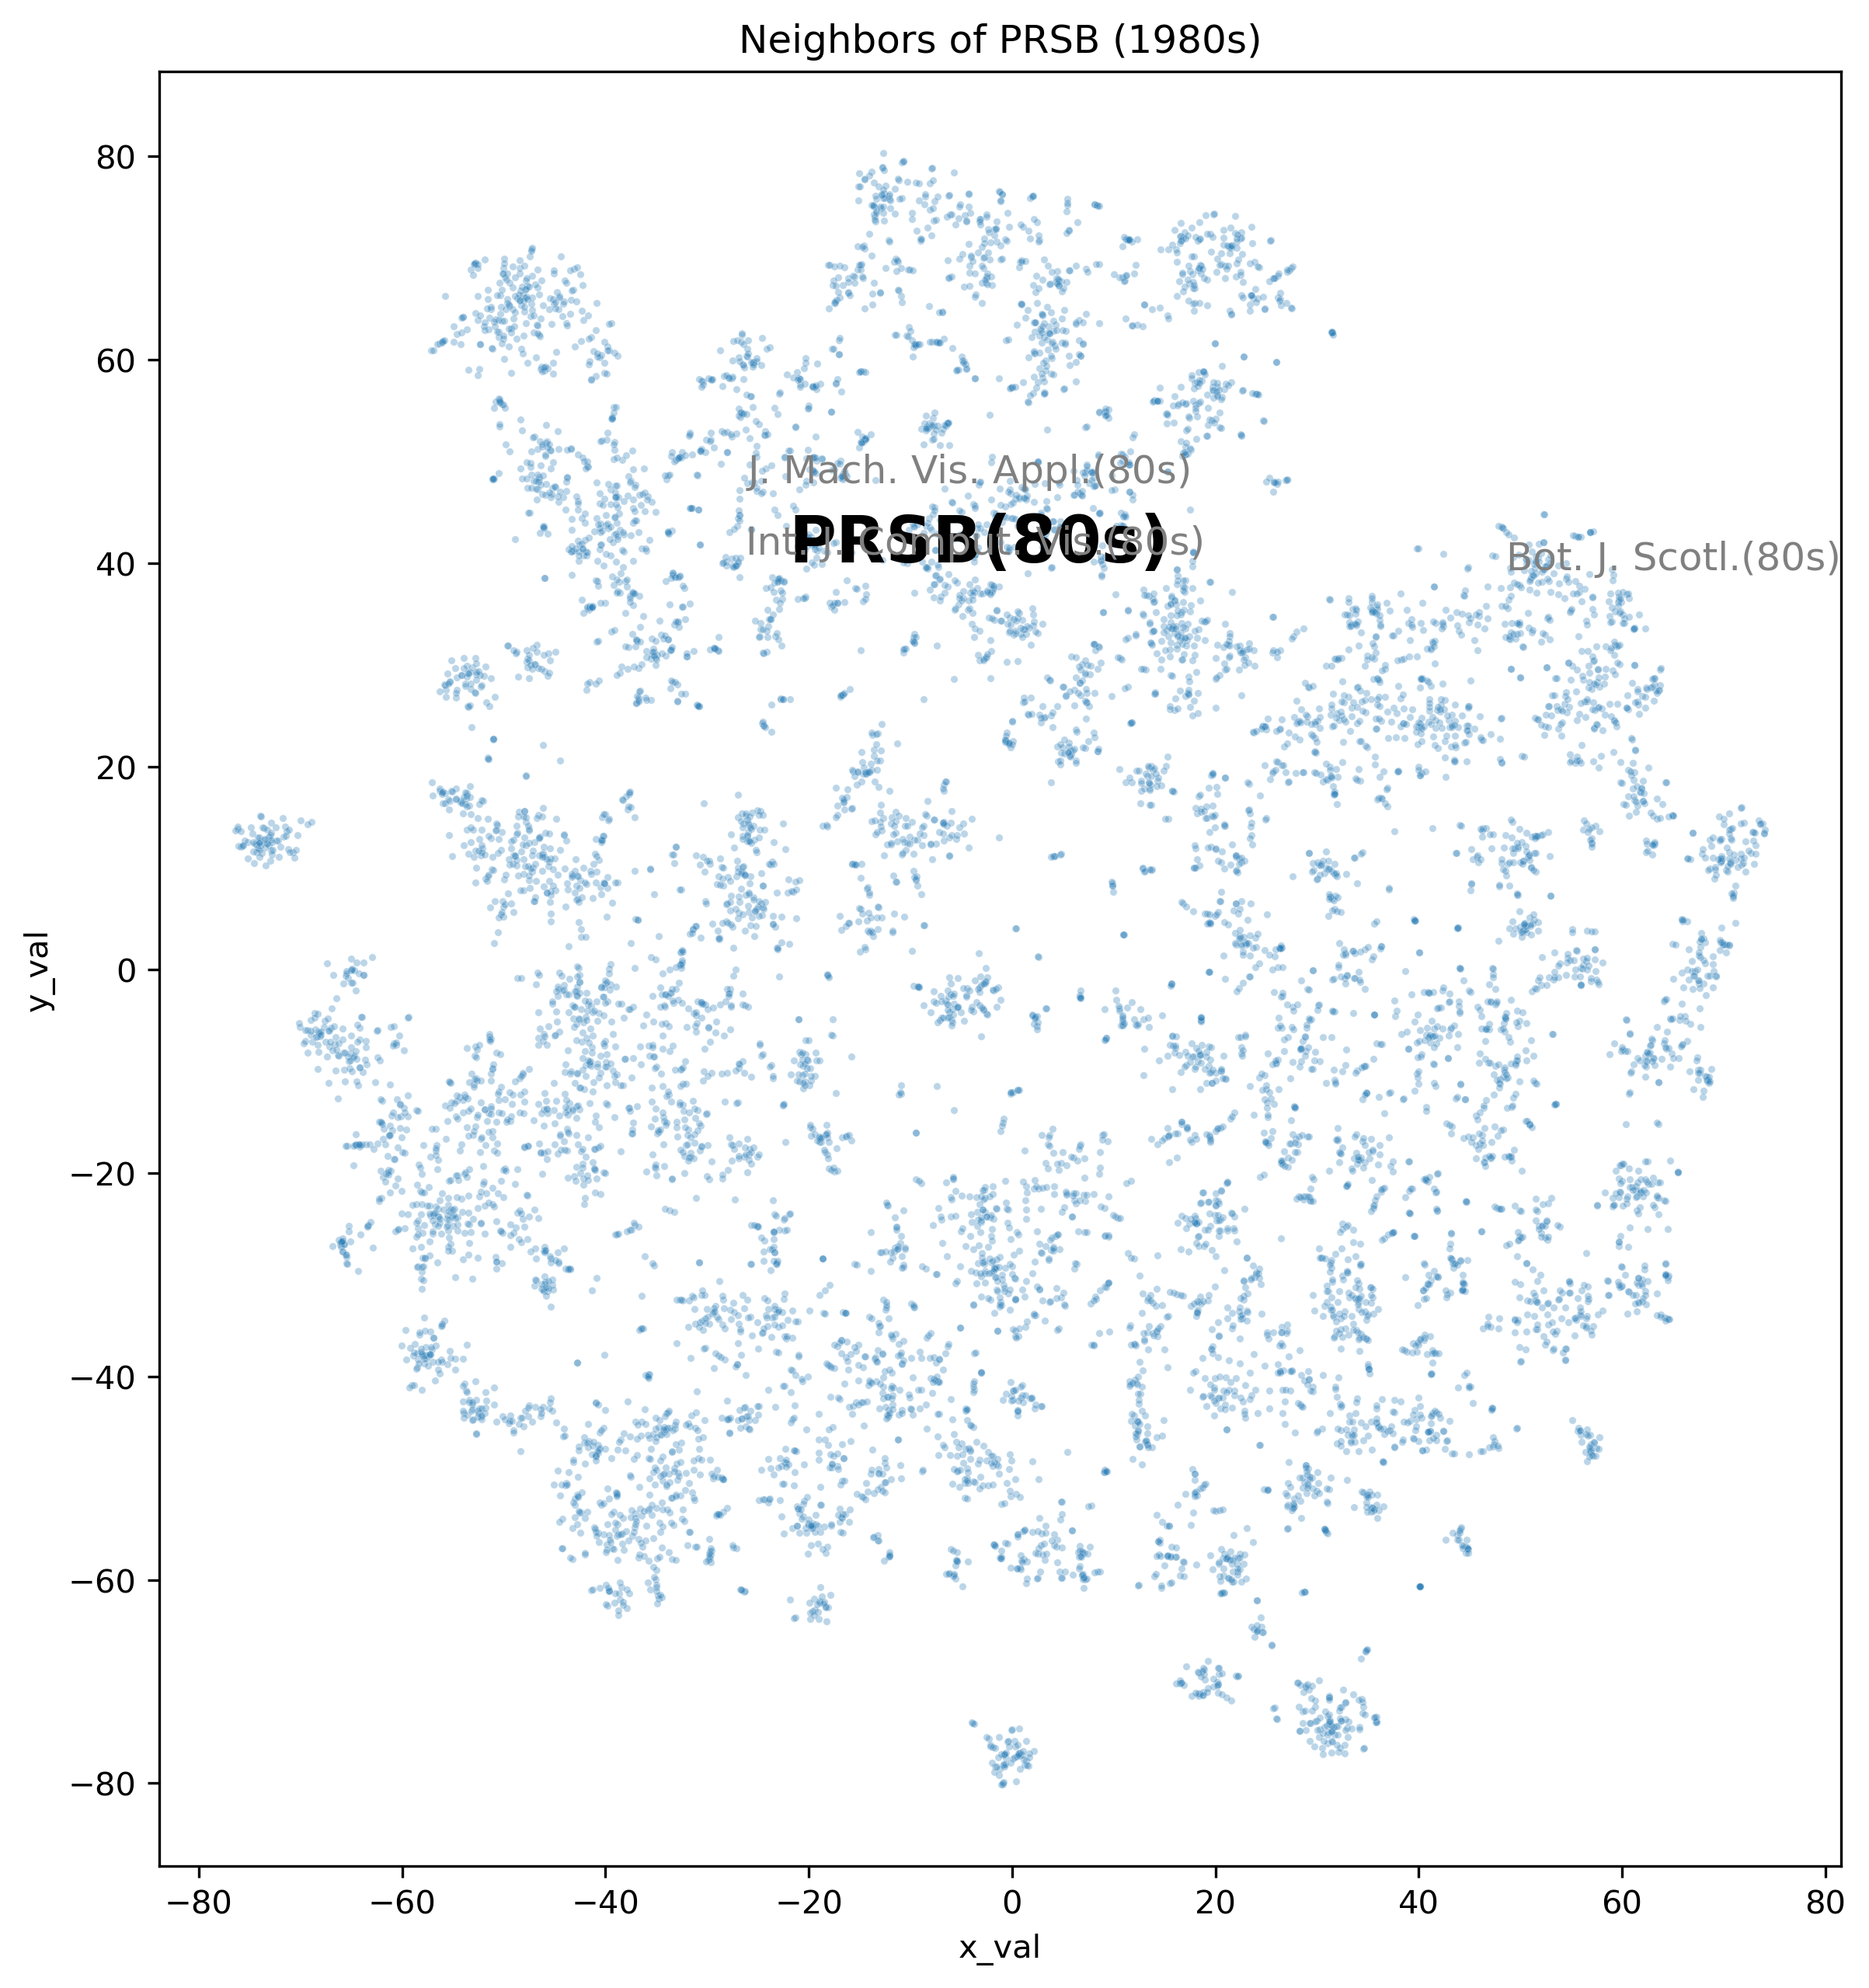

In [76]:
start_year, end_year = 1980, 1989
wv = model.load_wv(start_year, end_year, 100, 10)

tups = wv.most_similar(center_VID, topn=3)
neighbor_VID_list = []
for tup in tups:
    neighbor_VID = tup[0]
    neighbor_VID_list.append(neighbor_VID)

print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==neighbor_VID]['OriginalVenue'].values[0])

fig2 = plot_knn_map(start_year, end_year, ref_start_year, ref_end_year,100, 10, model,
                    axis_off=False, auto_zoom=False, crop=False, left_lim=30, right_lim=33, low_lim=-64, up_lim=-60, 
                    annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

2024-11-12 00:09:15 -- start loading word vectors...
2024-11-12 00:09:15 -- word vectors loaded, and its shape is: (15019, 100)
number of neighbors:  3
Ecology Letters
Trends in Ecology and Evolution
Philosophical Transactions of the Royal Society B
-----------------------
2024-11-12 00:09:15 -- start comparing 1970-1979 with the 1990-1999
2024-11-12 00:09:15 -- start loading word vectors...
2024-11-12 00:09:15 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-12 00:09:15 -- start loading word vectors...
2024-11-12 00:09:15 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-12 00:09:15 -- the number of shared VIDs between this two decades: 4831
2024-11-12 00:09:15 -- start aligning...
2024-11-12 00:09:15 -- start reducing dimension...
2024-11-12 00:09:38 -- finish.


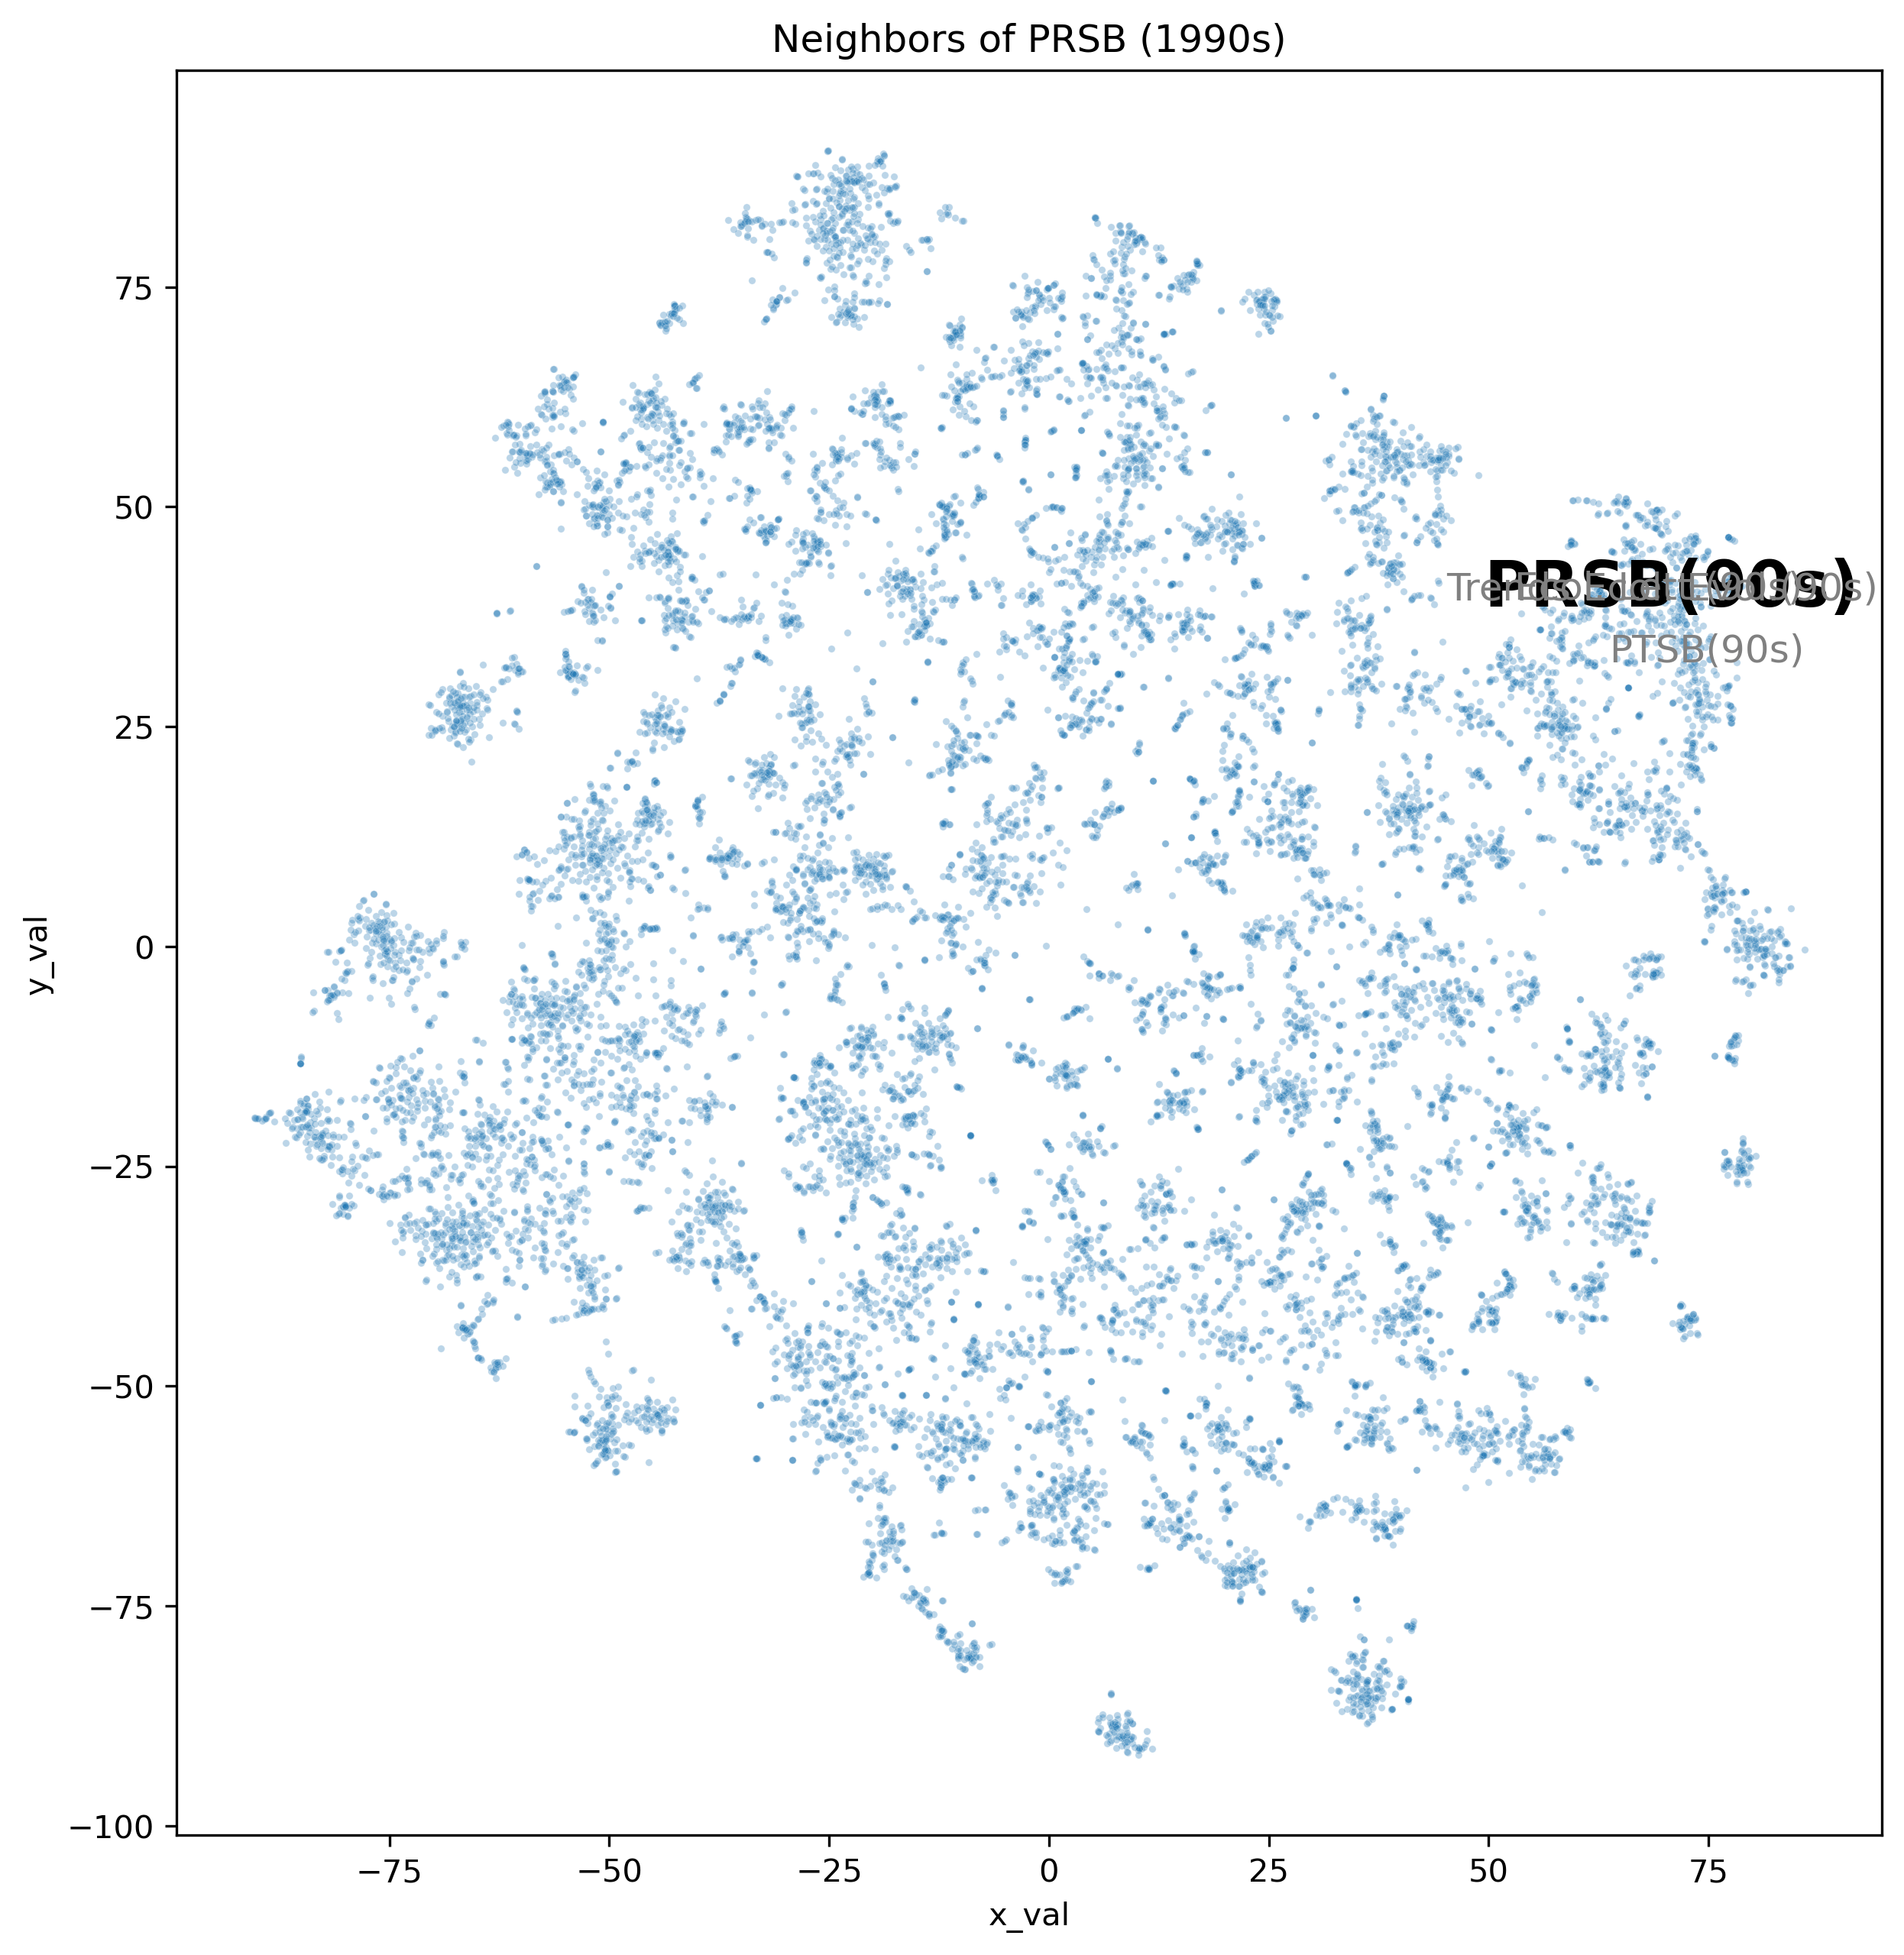

In [77]:
start_year, end_year = 1990, 1999
wv = model.load_wv(start_year, end_year, 100, 10)

tups = wv.most_similar(center_VID, topn=3)
neighbor_VID_list = []
for tup in tups:
    neighbor_VID = tup[0]
    neighbor_VID_list.append(neighbor_VID)

print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==neighbor_VID]['OriginalVenue'].values[0])

fig2 = plot_knn_map(start_year, end_year, ref_start_year, ref_end_year,100, 10, model,
                    axis_off=False, auto_zoom=False, crop=False, left_lim=-70, right_lim=-50, low_lim=0, up_lim=6, 
                    annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

# Final plot

In [4]:
model = p2v.P2V()

data_dir:  /mnt/d/projects/diachronic-p2v/data
2024-11-15 13:57:36 -- start loading Mag_venue_info_df
2024-11-15 13:57:36 -- finish.
2024-11-15 13:57:36 -- start loading labeled_journal_info_df
2024-11-15 13:57:36 -- finish.


In [5]:
center_vname = 'Proceedings of The Royal Society B: Biological Sciences'
center_VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==center_vname]['VenueID'].values[0]

abbr_dict = {'Trends in Ecology and Evolution': 'Trends Ecol. Evol.', 
             'Philosophical Transactions of the Royal Society B': 'PTRSB',	
             'Ecology Letters': 'Ecol. Lett.',	
             'International Journal of Computer Vision': 'Int. J. Comput. Vis.',
             'Botanical Journal of Scotland': 'Bot. J. Scotl.',
             'Proceedings of The Royal Society B: Biological Sciences': 'PRSB',
             'Journal of Machine Vision and Applications': 'J. Mach. Vis. Appl.',
             'The Journal of Experimental Biology': 'J. Exp. Biol.',
             'Current Topics in Developmental Biology': 'Curr. Top. Dev. Biol.'}

2024-11-15 13:57:42 -- start loading wv_2d...
2024-11-15 13:57:42 -- finish.
2024-11-15 13:57:42 -- start loading word vectors...
2024-11-15 13:57:42 -- word vectors loaded, and its shape is: (5686, 100)
number of neighbors:  3
Philosophical Transactions of the Royal Society B
Current Topics in Developmental Biology
The Journal of Experimental Biology
2024-11-15 13:57:42 -- start loading wv_2d...
2024-11-15 13:57:43 -- finish.
2024-11-15 13:57:43 -- start loading word vectors...
2024-11-15 13:57:43 -- word vectors loaded, and its shape is: (9337, 100)
number of neighbors:  3
International Journal of Computer Vision
Botanical Journal of Scotland
Journal of Machine Vision and Applications
2024-11-15 13:57:43 -- start loading wv_2d...
2024-11-15 13:57:43 -- finish.
2024-11-15 13:57:43 -- start loading word vectors...
2024-11-15 13:57:43 -- word vectors loaded, and its shape is: (15019, 100)
number of neighbors:  3
Ecology Letters
Trends in Ecology and Evolution
Philosophical Transactions 

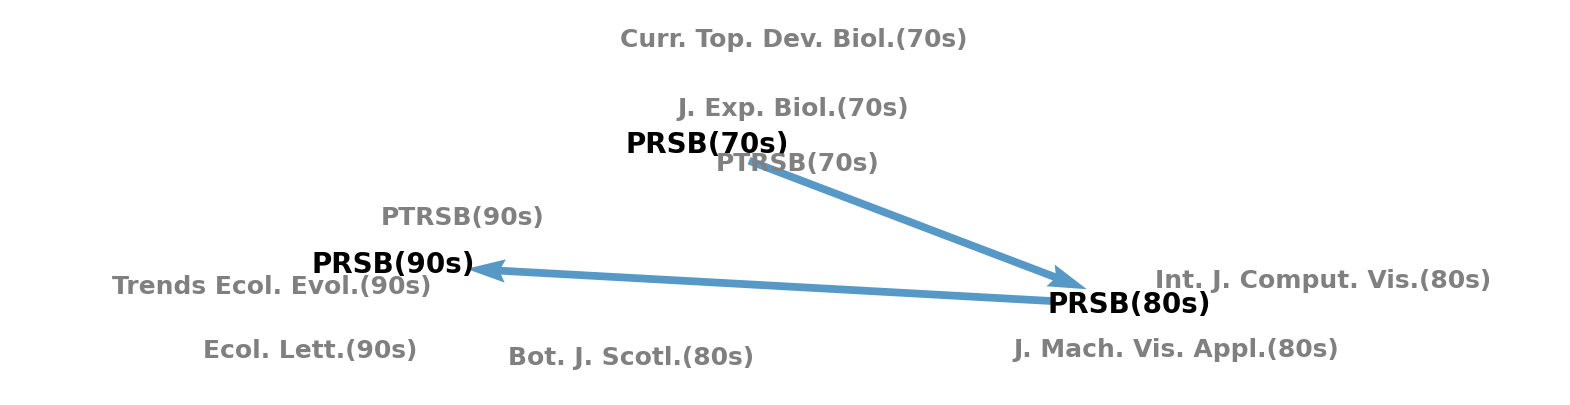

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(20, 5))
ax1 = plt.gca()

x, y = [], []
texts = []
center_venue_texts = []

for start_year, end_year in [(1970, 1979), (1980, 1989), (1990, 1999)]:
    wv_2d = model.load_wv_2d(start_year, end_year, 100, 10)
    plot_df = pd.DataFrame(wv_2d)

    if start_year in [1970, 1980]:
        plot_df['x_val'] = -1 * plot_df['x_val']

    point_alpha = 0
    sns.scatterplot(data=plot_df, 
                    x='x_val', 
                    y='y_val', 
                    alpha=point_alpha,
                    s=5,
                    ax=ax1)
    ax1.axis('off')

    center_venue_texts.append(ax1.text(plot_df[plot_df.VID==center_VID].x_val.values[0], 
                                       plot_df[plot_df.VID==center_VID].y_val.values[0], 
                                       abbr_dict[center_vname]+f'({str(start_year)[-2:]}s)',
                                       fontsize=20, ha='center', va='center',
                                       color='k',
                                       fontweight='bold',))
    x.append(plot_df[plot_df.VID==center_VID].x_val.values[0])
    y.append(plot_df[plot_df.VID==center_VID].y_val.values[0])
    if len(x) > 1:
        ax1.quiver(x[-2]+0.1*(x[-1]-x[-2]), y[-2]+0.1*(y[-1]-y[-2]), 
                   0.8*(x[-1]-x[-2]), 0.8*(y[-1]-y[-2]), 
                   angles='xy', scale_units='xy', width=0.005, scale=1, color='tab:blue', alpha=0.75)

    wv = model.load_wv(start_year, end_year, 100, 10)
    tups = wv.most_similar(center_VID, topn=3)
    neighbor_VID_list = []
    for tup in tups:
        neighbor_VID = tup[0]
        neighbor_VID_list.append(neighbor_VID)

    print('number of neighbors: ', len(neighbor_VID_list))
    for neighbor_VID in neighbor_VID_list:
        print(model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==neighbor_VID]['OriginalVenue'].values[0])

    for VID in neighbor_VID_list:
        texts.append(ax1.text(plot_df[plot_df.VID==VID].x_val.values[0], 
                              plot_df[plot_df.VID==VID].y_val.values[0], 
                              abbr_dict[model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==VID]['OriginalVenue'].values[0]]+f'({str(start_year)[-2:]}s)',
                              fontsize=18, ha='center', va='center',
                              color='gray',
                              fontweight='bold',))
    
ax1.set_xlim(-110, 80)
ax1.set_ylim(-55, 15)

x_ = np.linspace(min(x), max(x), 300)
y_ = np.interp(x_, x, y)

adjust_text(texts, objects=center_venue_texts, x=x_, y=y_,
            # max_move=(200, 200),
            # force_text=(0.4, 0.8), force_statics=(0.8, 1.6), 
            expand=(1.1, 2.3),
            # arrowprops=dict(arrowstyle='->', color='red')
            )
plt.show()

In [7]:
fig.savefig('diachronic-p2v/figures/semantic_change/arrows.pdf', 
            transparent=True, bbox_inches='tight', )